# Film Junky Union Movie Review Sentiment

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

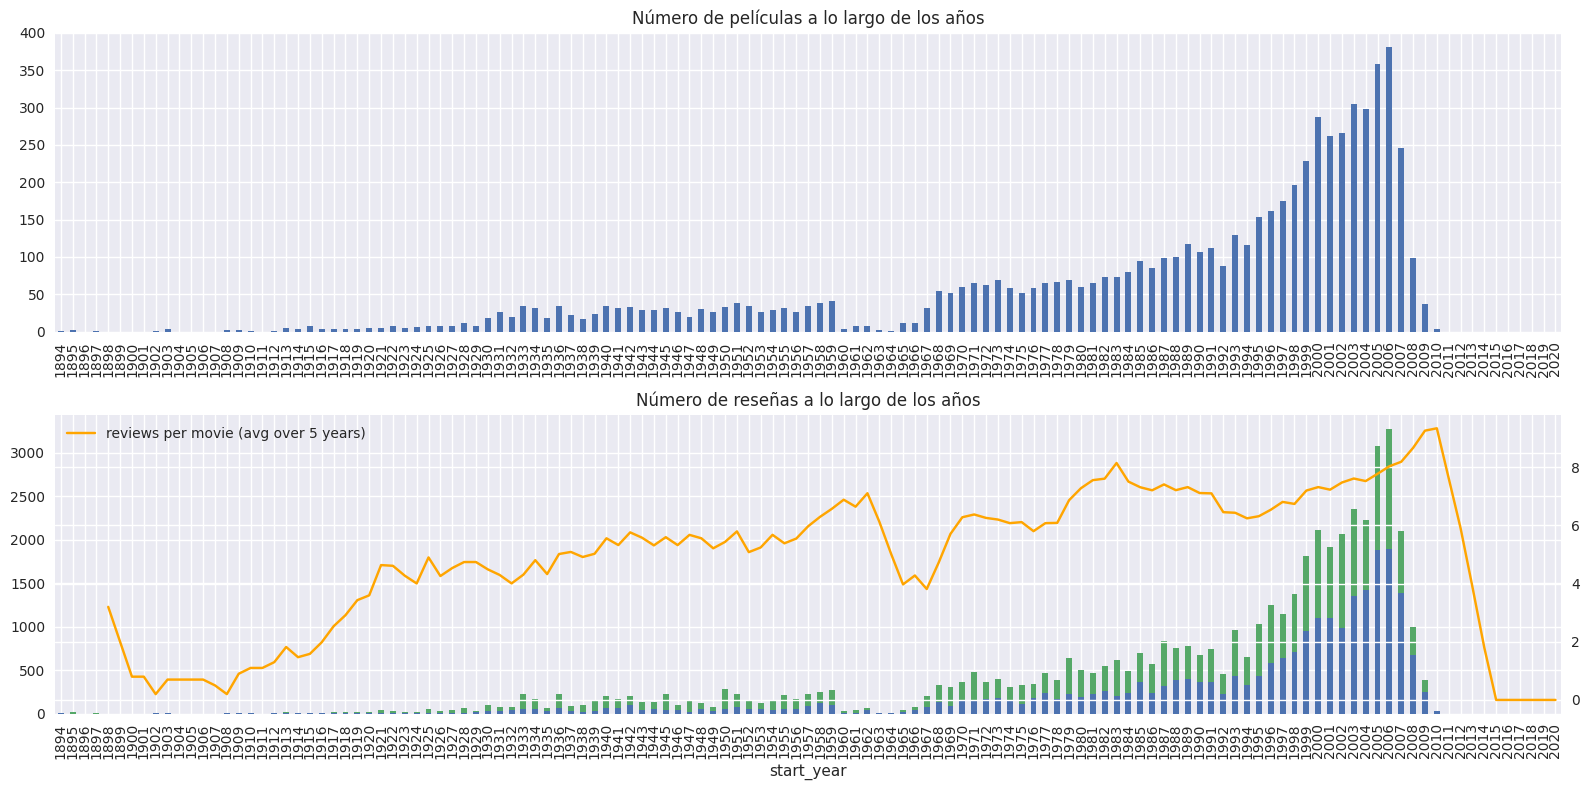

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

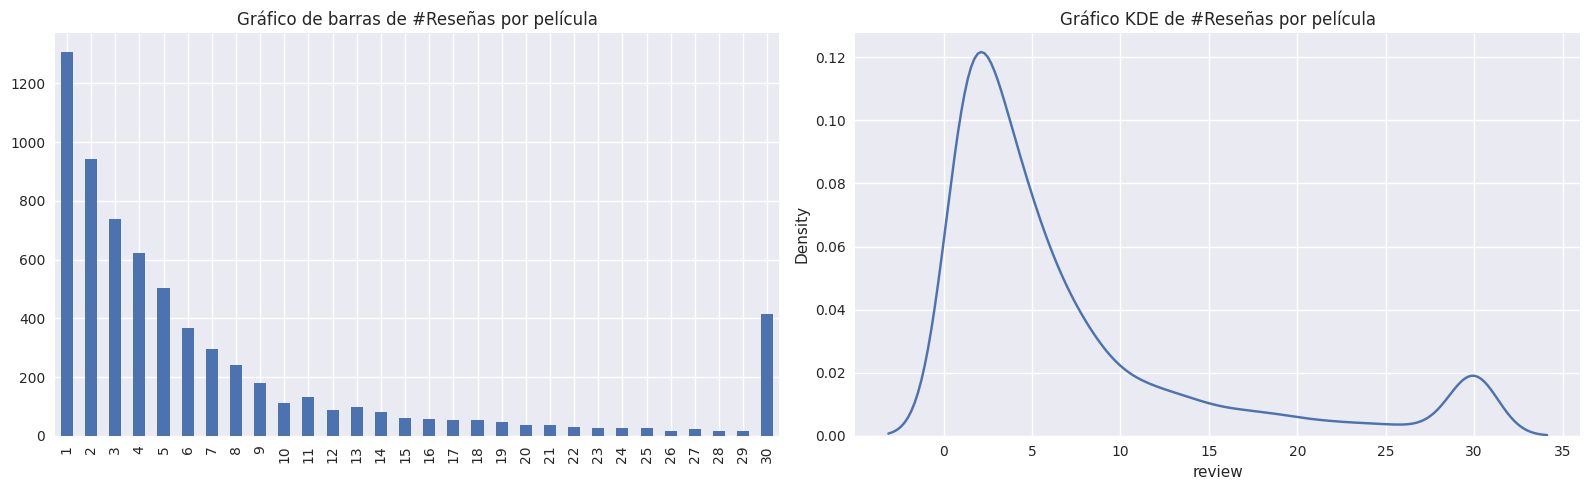

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

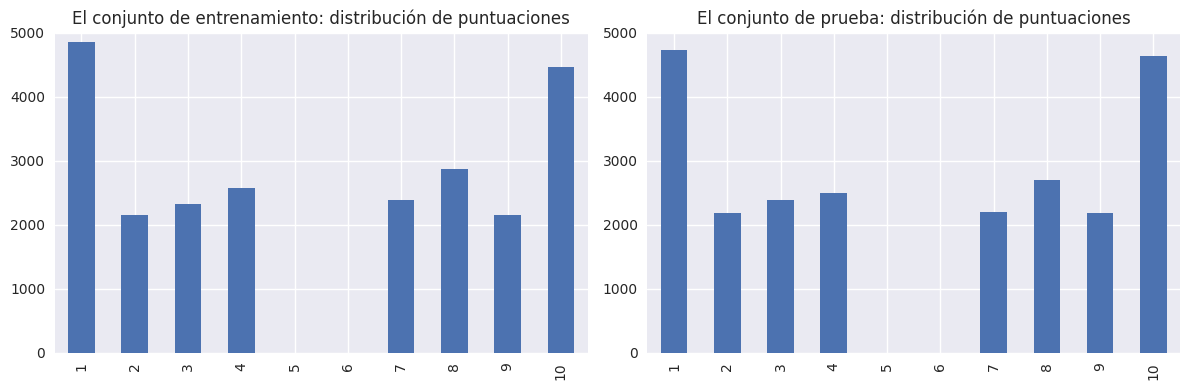

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


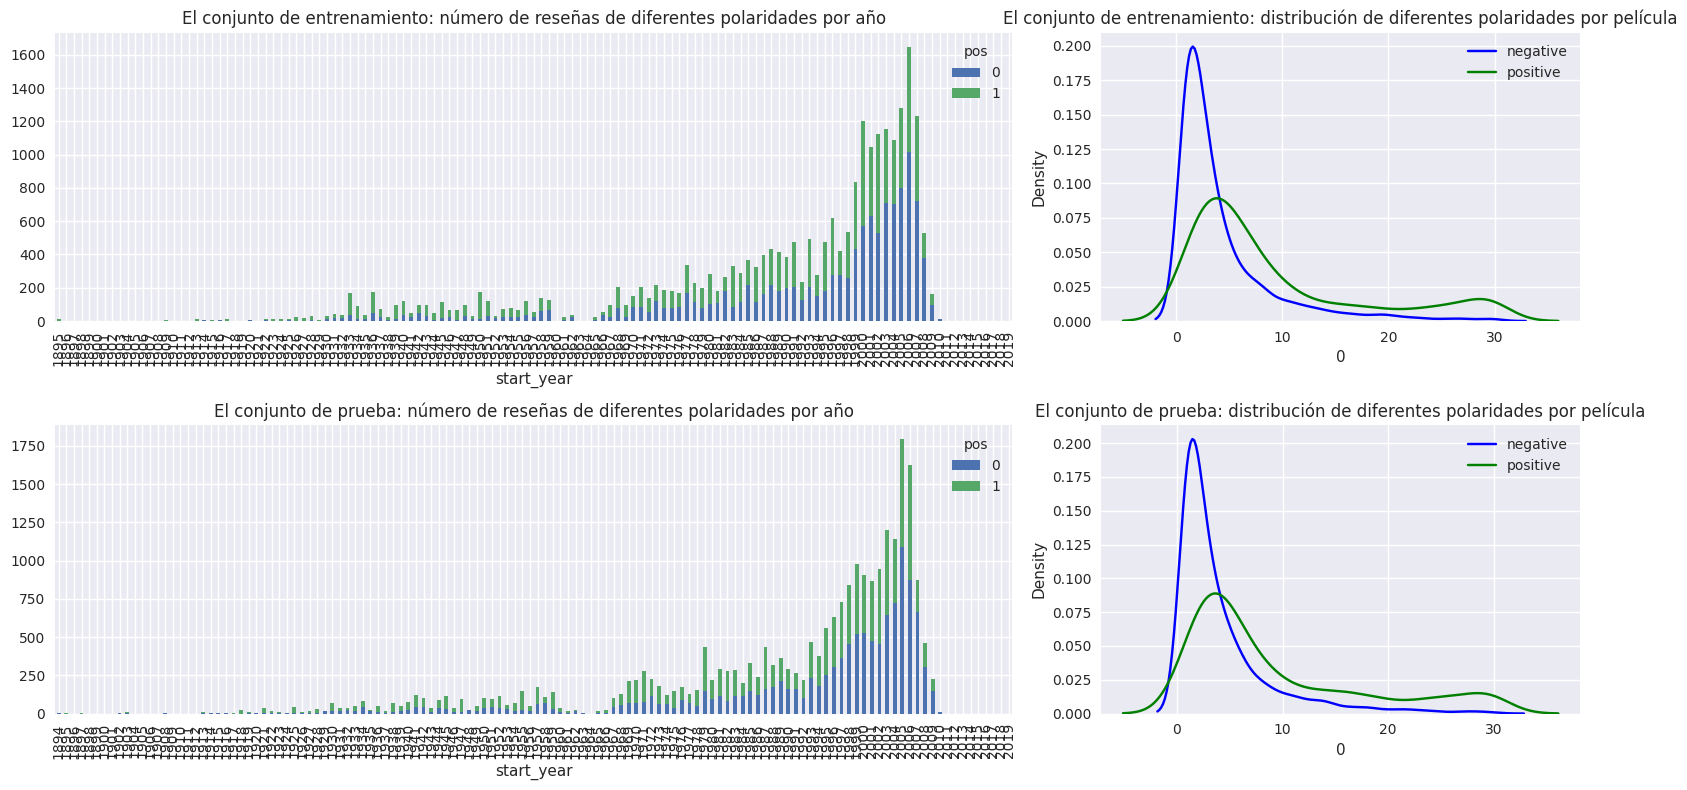

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        color = 'blue' if type == 'train' else 'green'

        # F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


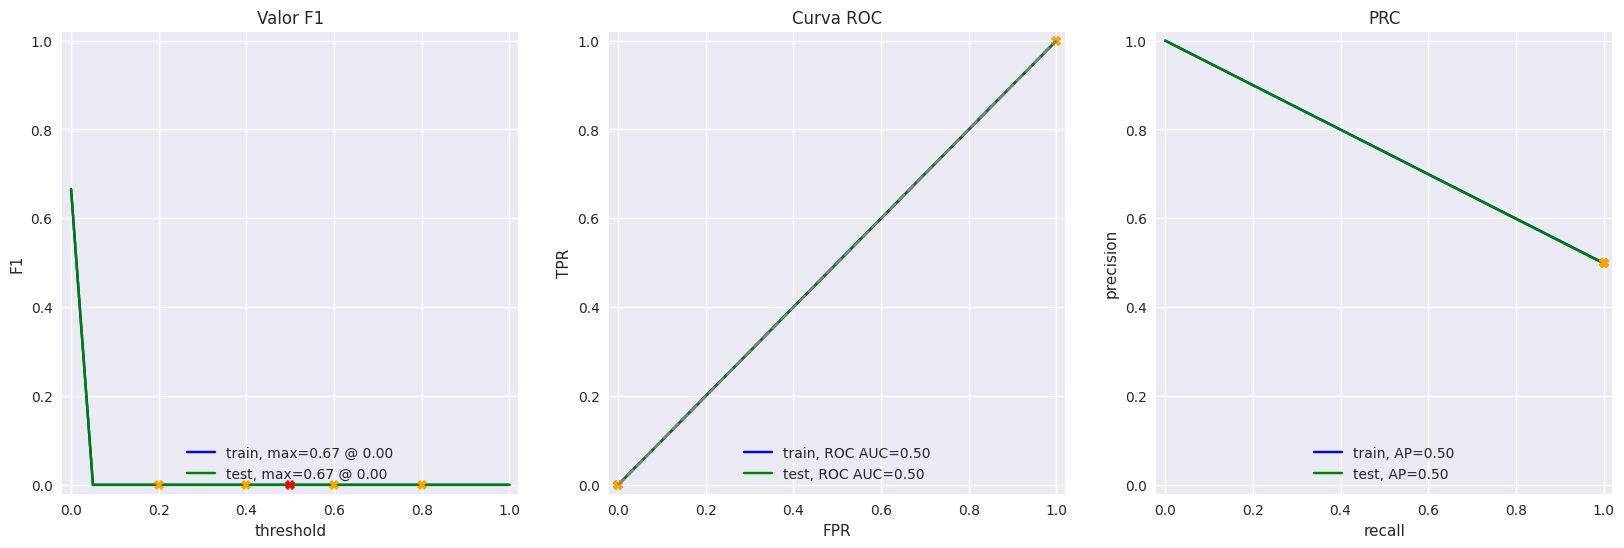

In [13]:
from sklearn.dummy import DummyClassifier
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(np.zeros(len(train_target)).reshape(-1, 1), train_target)
evaluate_model(model_0, np.zeros(len(train_target)).reshape(-1, 1), train_target, np.zeros(len(test_target)).reshape(-1, 1), test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = stopwords.words('english')

In [16]:
vectorizer_1 = TfidfVectorizer(max_features=5000, stop_words=stop_words)
train_features_1 = vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer_1.transform(df_reviews_test['review_norm'])

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


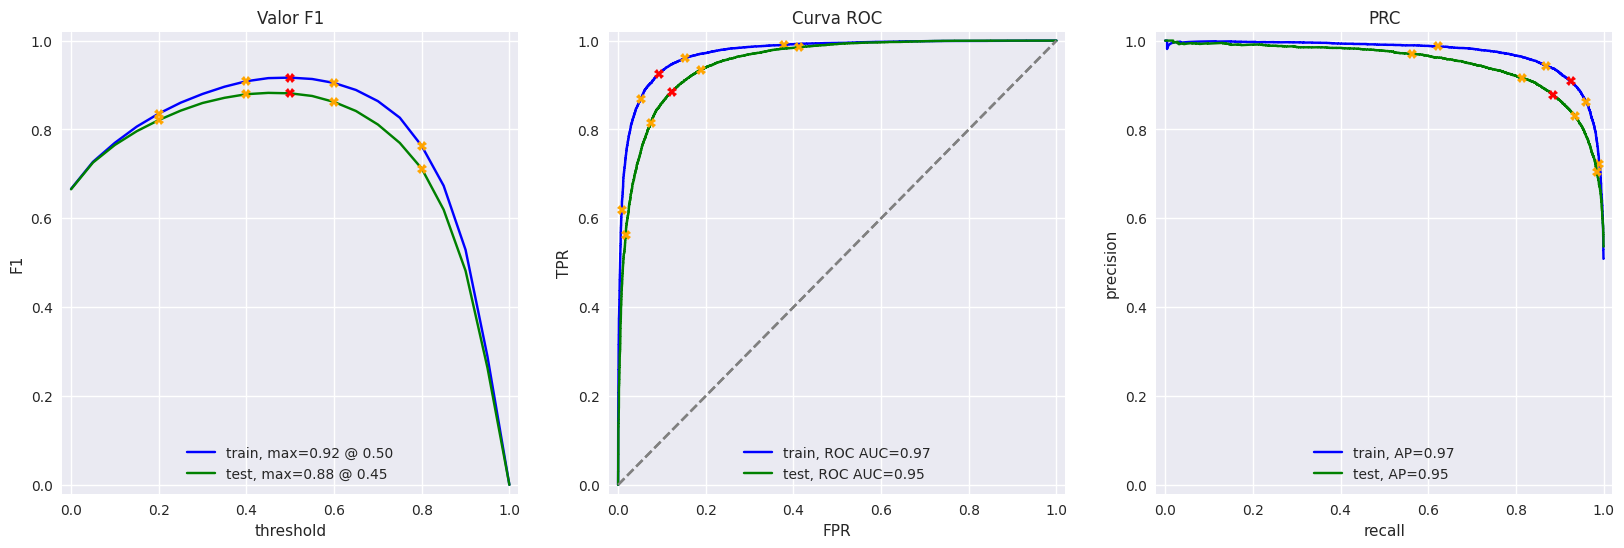

In [17]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [20]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [21]:
tfidf_vectorizer_3 = TfidfVectorizer(max_features=5000)
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


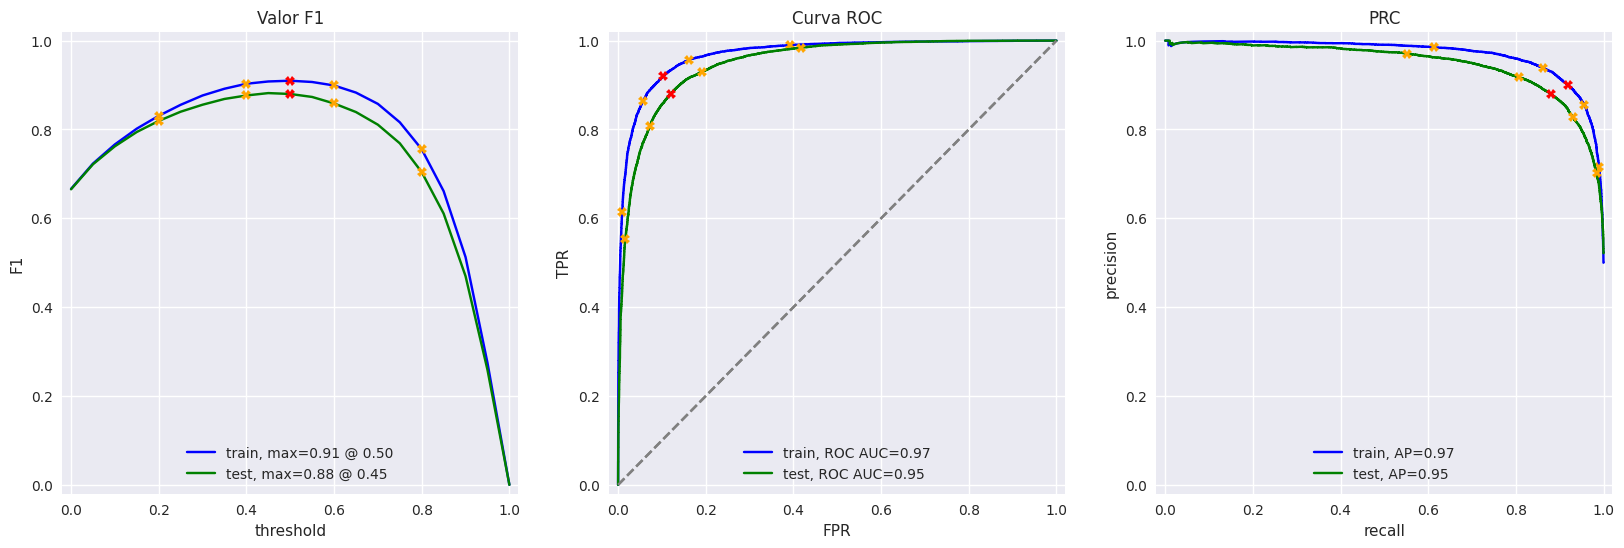

In [22]:
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [23]:
from lightgbm import LGBMClassifier

In [24]:
tfidf_vectorizer_4 = tfidf_vectorizer_3
train_features_4 = tfidf_vectorizer_4.transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


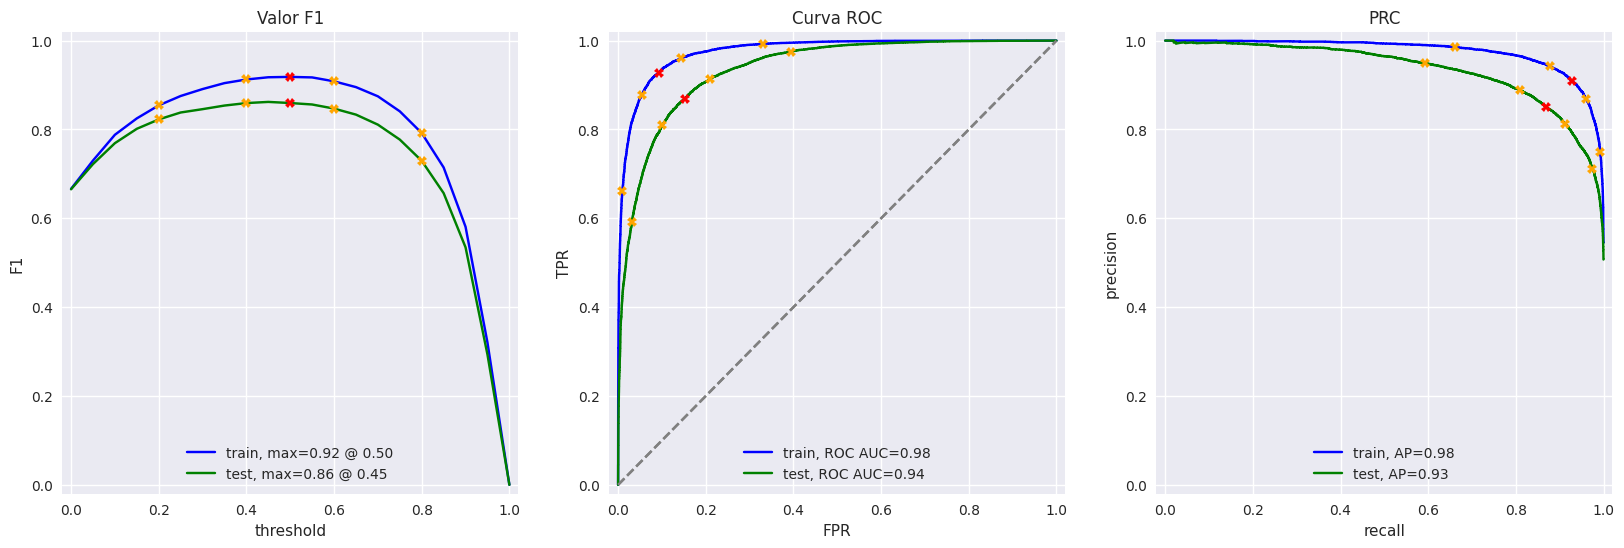

In [25]:
model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Modelo 9 - BERT

In [26]:
import torch
import transformers
from tqdm import tqdm

In [27]:
from transformers import DistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    device = torch.device('cuda' if torch.cuda.is_available() and force_device != 'cpu' else 'cpu')
    model_bert.to(device)
    model_bert.eval()

    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), disable=disable_progress_bar):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
            embeddings.append(cls_embeddings)

    return np.concatenate(embeddings, axis=0)

In [37]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

#Proceso un subconjunto pequeño
sample_size = 100
texts_train_9 = df_reviews_train['review'].iloc[:sample_size].tolist()
texts_test_9 = df_reviews_test['review'].iloc[:sample_size].tolist()
train_target_9 = train_target.iloc[:sample_size]
test_target_9 = test_target.iloc[:sample_size]

In [38]:
train_features_9 = BERT_text_to_embeddings(texts_train_9, batch_size=8, force_device='cpu')
test_features_9 = BERT_text_to_embeddings(texts_test_9, batch_size=8, force_device='cpu')

100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


          train  test
Accuracy   0.98  0.87
F1         0.99  0.88
APS        1.00  0.94
ROC AUC    1.00  0.94


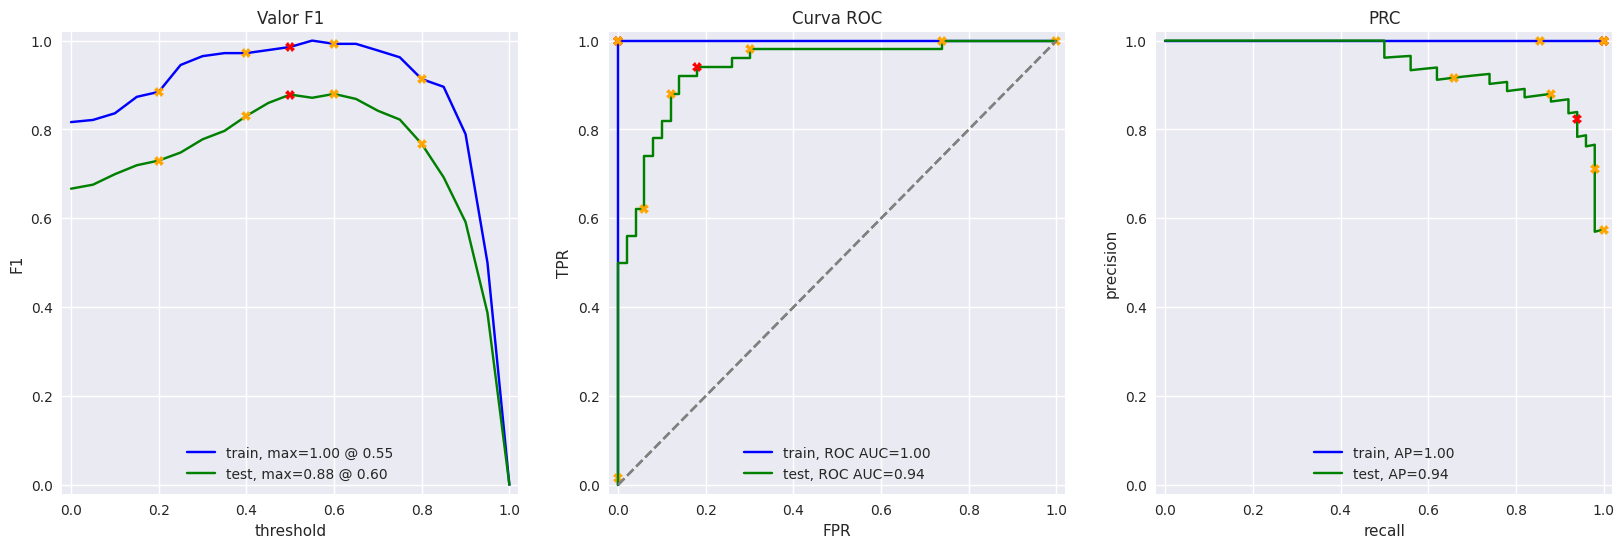

In [39]:
from sklearn.linear_model import LogisticRegression
model_9 = LogisticRegression(max_iter=1000)
model_9.fit(train_features_9, train_target_9)
evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)

In [42]:
#Guardar los embeddings para no recalcularlos
np.savez_compressed('distilbert_embeddings.npz',
                    train_features_9=train_features_9,
                    test_features_9=test_features_9,
                    train_target_9=train_target_9.values,
                    test_target_9=test_target_9.values)

In [44]:
#Para cargarlo nuevamente usare el codigo de abajo
with np.load('distilbert_embeddings.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']
    train_target_9 = data['train_target_9']
    test_target_9 = data['test_target_9']

## Mis reseñas

### Modelo 1

In [50]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    sentiment = 'Positiva' if my_reviews_pred_prob[i] >= 0.5 else 'Negativa'
    print(f'{my_reviews_pred_prob[i]:.2f} ({sentiment}):  {review}')

0.19 (Negativa):  i did not simply like it not my kind of movie
0.16 (Negativa):  well i was bored and felt asleep in the middle of the movie
0.60 (Positiva):  i was really fascinated with the movie
0.10 (Negativa):  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.21 (Negativa):  i didnt expect the reboot to be so good writers really cared about the source material
0.54 (Positiva):  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05 (Negativa):  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91 (Positiva):  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [51]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didnt expect the reboot to be so good writers really cared about the source material
0.73:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [52]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it not my kind of movie
0.57:  well i was bored and felt asleep in the middle of the movie
0.70:  i was really fascinated with the movie
0.63:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didnt expect the reboot to be so good writers really cared about the source material
0.86:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [54]:
texts = my_reviews['review_norm'].tolist()  # ✅ convertir a lista

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.07:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.02:  i didnt expect the reboot to be so good writers really cared about the source material
0.73:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.99:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

A lo largo del proyecto se fue evaluando multiples enfoques para la clasificacion de reseñas, incluyendo modelos lineales como regresion logistica, tecnicas de representacion de texto como TF-IDF, y metodos mas avanzados con embeddings BERT. Ahora bien, el modelo basado en TF-IDF junto con regresion logistica mostro un desempeño solido, alcanzando valores de F1 de 0.88 en el conjunto de prueba, con metricas como ROC AUC y APS tambien por encima de 0.95, lo que lo convierte en una opcion mas eficiente y robusta para esta tarea.

Por otro lado, los modelos basados en BERT que se exploraron con un enfoque simple, sin ajustes finos en los hiperparametros ni optimizaciones especificas. Aunque estos modelos no superaron en desempeño deseado a las alternativas tradicionales en este caso, queda abierta la posibilidad de que variantes mas sofisticadas (como DistilBERT) que puedan ofrecer mejores resultados con mas recursos computacionalmente hablando.

En resumen, TF-IDF combinado con modelos lineales continua siendo una opcion rapida y efectiva para clasificacion de texto, y para futuras iteraciones del proyecto podrian beneficiarse de explorar modelos optimizados basados en transformers y tecnicas de ensamblado como XGBoost para aprovechar lo mejor.